### Problem Statement

A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure and ICP transformation. Due to noise in wheel odometry it generated a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import gtsam

Generating X, Y coordinates and $\theta$ separately for the trajectory

In [2]:
def genTraj():
    init = (0, 0)

    # Forward I
    num = 20; xSt = -5; ySt = -8; leng = 9.0; step = float(leng)/num
    X1 = np.zeros(num); Y1 = np.zeros(num); X1[0] = xSt; Y1[0] = ySt
    for i in range(1, num):
        X1[i] = X1[i-1] + step
        Y1[i] = ySt

    # UTurn I
    rad = 2.5; num = 20
    xCen = X1[-1]; yCen = Y1[-1] + rad
    thetas = np.linspace(-math.pi/2, math.pi/2, num)
    X2 = np.zeros(num); Y2 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X2[i] = (xCen + rad*math.cos(theta))
        Y2[i] = (yCen + rad*math.sin(theta))

    # Backward I
    num = 20; leng = 10.0; step = float(leng)/num
    xSt = X2[-1]; ySt = Y2[-1]
    X3 = np.zeros(num); Y3 = np.zeros(num); X3[0] = xSt; Y3[0] = ySt 
    for i in range(1, num):
        X3[i] = X3[i-1] - step
        Y3[i] = ySt

    # UTurn II
    rad = 2.6; num = 20
    xCen = X3[-1]; yCen = Y3[-1] - rad
    thetas = np.linspace(math.pi/2, 3*math.pi/2, num)
    X4 = np.zeros(num); Y4 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X4[i] = (xCen + rad*math.cos(theta))
        Y4[i] = (yCen + rad*math.sin(theta))

    # Forward II
    num = 20; leng = 11.0; step = float(leng)/num
    xSt = X4[-1]; ySt = Y4[-1]
    X5 = np.zeros(num); Y5 = np.zeros(num); X5[0] = xSt; Y5[0] = ySt
    for i in range(1, num):
        X5[i] = X5[i-1] + step
        Y5[i] = ySt

    # UTurn III
    rad = 2.7; num = 20
    xCen = X5[-1]; yCen = Y5[-1] + rad
    thetas = np.linspace(-math.pi/2, math.pi/2, num)
    X6 = np.zeros(num); Y6 = np.zeros(num)
    for i, theta in enumerate(thetas):
        X6[i] = (xCen + rad*math.cos(theta))
        Y6[i] = (yCen + rad*math.sin(theta))	

    # Assemble
    X = np.concatenate([X1, X2, X3, X4, X5, X6]); Y = np.concatenate([Y1, Y2, Y3, Y4, Y5, Y6])
    THETA = np.array(getTheta(X, Y))

    return (X, Y, THETA)


def getTheta(X ,Y):
    THETA = [None]*len(X)
    for i in range(1, len(X)-1):
        if(X[i+1] == X[i-1]):
            if (Y[i+1]>Y[i-1]):
                THETA[i] = math.pi/2
            else:
                THETA[i] = 3*math.pi/2
            continue

        THETA[i] = math.atan((Y[i+1]-Y[i-1])/(X[i+1]-X[i-1]))

        if(X[i+1]-X[i-1] < 0):
            THETA[i] += math.pi 

    if X[1]==X[0]:
        if Y[1] > Y[0]:
            THETA[0] = math.pi/2
        else:
            THETA[0] = 3*math.pi/2
    else:
        THETA[0] = math.atan((Y[1]-Y[0])/(X[1]-X[0]))

    if X[-1] == X[len(Y)-2]:
        if Y[1] > Y[0]:
            THETA[-1] = math.pi/2
        else:
            THETA[-1] = 3*math.pi/2
    else:
        THETA[-1] = math.atan((Y[-1]-Y[len(Y)-2])/(X[-1]-X[len(Y)-2]))

    return THETA

In [3]:
(X, Y, THETA) = genTraj()

Drawing functions for plotting one, two and three trajectories simultaneously.

In [4]:
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'k-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'm->')

    plt.show()


def drawTwo(X1, Y1, THETA1, X2, Y2, THETA2):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    plt.legend()
    plt.show()


def drawThree(X1, Y1, THETA1, X2, Y2, THETA2, X3, Y3, THETA3):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    ax.plot(X3, Y3, 'go', label='Noisy')
    plt.plot(X3, Y3, 'k-')

    for i in range(len(THETA3)):
        x2 = 0.25*math.cos(THETA3[i]) + X3[i]
        y2 = 0.25*math.sin(THETA3[i]) + Y3[i]
        plt.plot([X3[i], x2], [Y3[i], y2], 'g->')

    plt.legend()
    plt.show()	


Ground Truth Trajectory

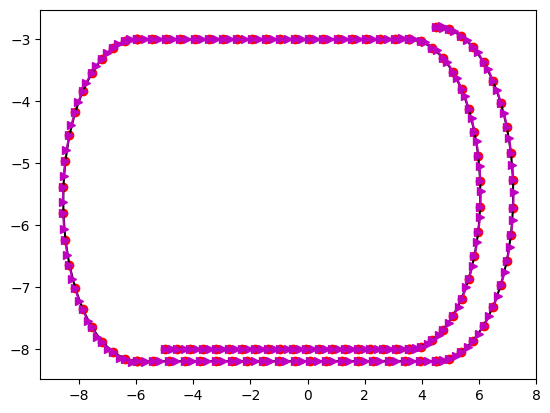

In [5]:
draw(X, Y, THETA)

Adding noise to the trajectory to simulate real life scenario.  
We could not directly add noise values to $X, Y, \theta$ parameters. Instead noise should be added to the odometry values.  
T1_w = $T^w_1$ = 1 with respect to the world

In [6]:
def addNoise(X, Y, THETA):
    xN = np.zeros(len(X)); yN = np.zeros(len(Y)); tN = np.zeros(len(THETA))
    xN[0] = X[0]; yN[0] = Y[0]; tN[0] = THETA[0]

    for i in range(1, len(X)):
        # Get T2_1
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])

        # Add noise
        if(i<5):
            xNoise = 0; yNoise = 0; tNoise = 0
        else:
            xNoise = np.random.normal(0, 0.03); yNoise = np.random.normal(0, 0.03); tNoise = np.random.normal(0, 0.03)
        del_xN = del_x + xNoise; del_yN = del_y + yNoise; del_thetaN = del_theta + tNoise

        # Convert to T2_1'
        T2_1N = np.array([[math.cos(del_thetaN), -math.sin(del_thetaN), del_xN], [math.sin(del_thetaN), math.cos(del_thetaN), del_yN], [0, 0, 1]])

        # Get T2_w' = T1_w' . T2_1'
        p1 = (xN[i-1], yN[i-1], tN[i-1])
        T1_wN = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_wN = np.dot(T1_wN, T2_1N)

        # Get x2', y2', theta2'
        x2N = T2_wN[0][2]
        y2N = T2_wN[1][2]
        theta2N = math.atan2(T2_wN[1, 0], T2_wN[0, 0])

        xN[i] = x2N; yN[i] = y2N; tN[i] = theta2N  

    # tN = getTheta(xN, yN)

    return (xN, yN, tN)

Noisy trajectory

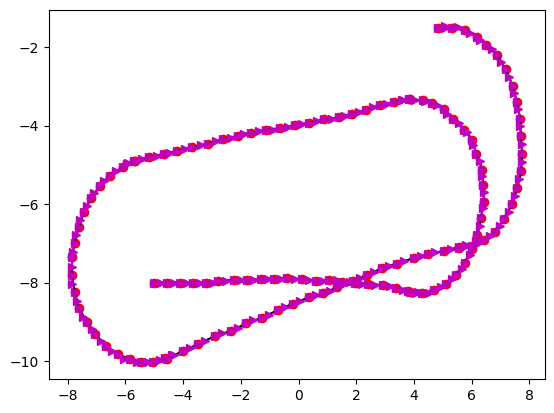

In [7]:
(xN, yN, tN) = addNoise(X, Y, THETA)
draw(xN, yN, tN)

## Backend Optimisation [G2O and GTSAM]





Generating G2O file. We would be using `VERTEX_SE2` and `EDGE_SE2` for our task.  
Information matrix for odometry edges, $\omega_{odom}$ = `500.0 0.0 0.0 500.0 0.0 500.0`   
Information matrix for loop closure edges, $\omega_{lc}$ = `700.0 0.0 0.0 700.0 0.0 700.0`  
Loop closure constraints are generated for the starting part of the trajectory. In practice, they would be detected by loop closure system using bag of visual words and transformation would be calculated using ICP.  
Fix the starting node in pose graph otherwise the optimized pose graph can occur anywhere on cartesian plane.  
Below figure is generated using `g2o_viewer`, in terminal after generating `noise.g2o`, run: `g2o_viewer noise.g2o`  

<img src="./results/loop_clousre_noisy.png" width="500" />


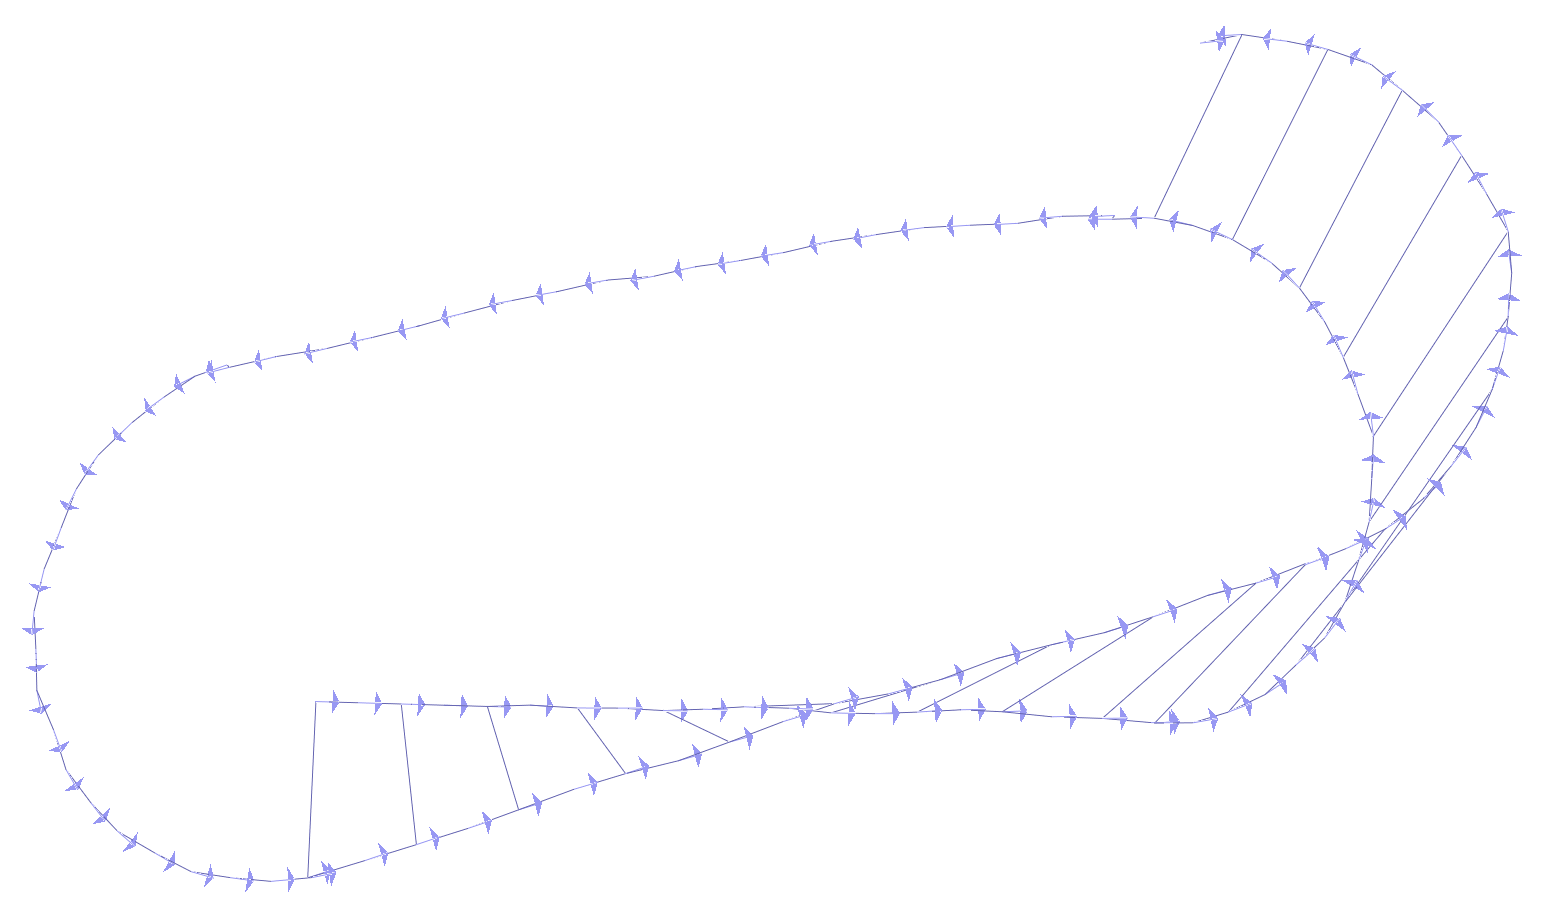

In [8]:
def writeOdom(X, Y, THETA):
    g2o = open('noise.g2o', 'w')

    for i, (x, y, theta) in enumerate(zip(X,Y,THETA)):
        line = "VERTEX_SE2 " + str(i) + " " + str(x) + " " + str(y) + " " + str(theta)
        g2o.write(line)
        g2o.write("\n")

    info_mat = "500.0 0.0 0.0 500.0 0.0 500.0"
    for i in range(1, len(X)):
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = str(T2_1[0][2])
        del_y = str(T2_1[1][2])
        del_theta = str(math.atan2(T2_1[1, 0], T2_1[0, 0]))

        line = "EDGE_SE2 "+str(i-1)+" "+str(i)+" "+del_x+" "+del_y+" "+del_theta+" "+info_mat
        g2o.write(line)
        g2o.write("\n")

    g2o.write("FIX 0")
    g2o.write("\n")
    # g2o.close()
    return g2o


def writeLoop(X, Y, THETA, g2o):
    sz = X.size

    pairs = []
    for i in range(0, 40, 2):
        pairs.append((i, i+80))
    # for i in range(len(X)):
    # 	pairs.append((0, i))

    info_mat = "700.0 0.0 0.0 700.0 0.0 700.0"

    for p in pairs:
        p1 = (X[p[0]], Y[p[0]], THETA[p[0]])
        p2 = (X[p[1]], Y[p[1]], THETA[p[1]])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = str(T2_1[0][2])
        del_y = str(T2_1[1][2])
        del_theta = str(math.atan2(T2_1[1, 0], T2_1[0, 0]))

        line = "EDGE_SE2 "+str(p[0])+" "+str(p[1])+" "+del_x+" "+del_y+" "+del_theta+" "+info_mat
        g2o.write(line)
        g2o.write("\n")

    g2o.close()

In [9]:
g2o = writeOdom(xN, yN, tN)
writeLoop(X, Y, THETA, g2o)

Optimize the pose graph using g2o binary and loads the optimized graph.  
G2O provides options to change the number of iteration steps, change the optimization solver and incorporate robust cost functions to minimize the impact of false loop closure constraints due to error in frontend.  

In [10]:
def optimize(g2o_path_to_bin = "../../../MR2022/Tutorial/g2o-master/bin/g2o"):
    cmd = g2o_path_to_bin+" -o opt.g2o noise.g2o"
    os.system(cmd)
    

def readG2o(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    X = []
    Y = []
    THETA = []

    for line in A:
        if "VERTEX_SE2" in line:
            line = line.strip()
            (ver, ind, x, y, theta) = line.split(' ')
            X.append(float(x))
            Y.append(float(y))
            THETA.append(float(theta.rstrip('\n')))

    return (X, Y, THETA)

Comparing Ground Truth and optimized trajectory.  

# Using EigenSparseCholesky poseDim -1 landMarkDim -1 blockordering 1
Read input from noise.g2o
Loaded 120 vertices
Loaded 139 edges
# graph is fixed by priors or already fixed vertex
Initial chi2 = 36125.318082
saving opt.g2o ... done.


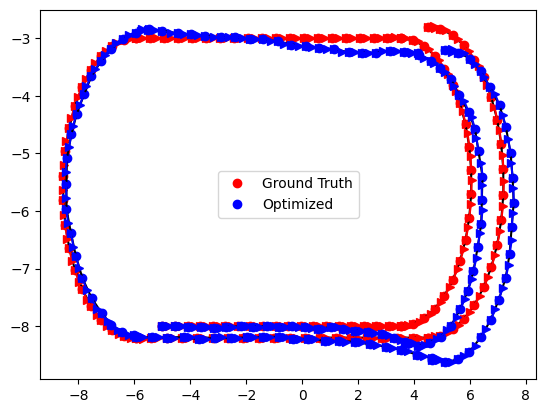

In [20]:
optimize()
(xOpt, yOpt, tOpt) = readG2o("opt.g2o")
drawTwo(X, Y, THETA, xOpt, yOpt, tOpt)

Comparing Ground Truth, optimized and noisy trajectory.  

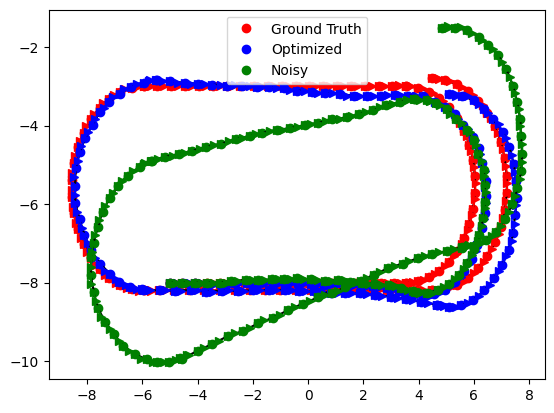

In [21]:
drawThree(X, Y, THETA, xOpt, yOpt, tOpt, xN, yN, tN)

In [11]:

def gtsam_optimisation(save_file, noiselc, x0, y0, t0):
	graph, initial = gtsam.readG2o(noiselc, is3D=False)
	priorModel = gtsam.noiseModel.Diagonal.Variances(gtsam.Point3(1e-2, 1e-2, 1e-4))
	graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(x0, y0, t0), priorModel))

	params = gtsam.LevenbergMarquardtParams()
	params.setVerbosity("Termination")  # this will show info about stopping conds
	optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

	result = optimizer.optimize()
	print("Optimization complete")
	print("initial error = ", graph.error(initial))
	print("final error = ", graph.error(result))

	print("Writing results to file: ", save_file)
	graphNoKernel, _ = gtsam.readG2o(noiselc, is3D=False)
	gtsam.writeG2o(graphNoKernel, result, save_file)
	print("Done!")

converged
errorThreshold: 10.0896225941 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 4 >? 100
Optimization complete
initial error =  18062.6590409621
final error =  10.089622594096898
Writing results to file:  opt_gtsam.g2o
Done!


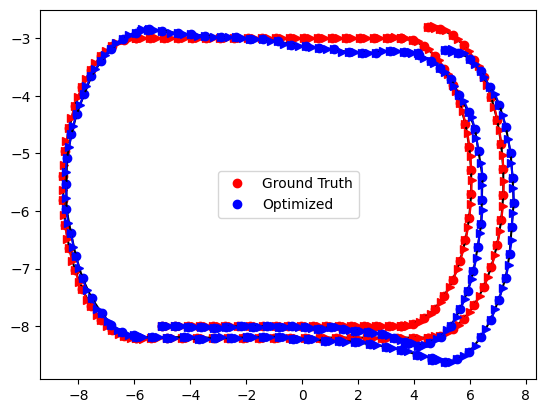

In [13]:
gtsam_optimisation("opt_gtsam.g2o", "noise.g2o", X[0], Y[0], THETA[0])
(xOpt, yOpt, tOpt) = readG2o("opt_gtsam.g2o")
drawTwo(X, Y, THETA, xOpt, yOpt, tOpt)

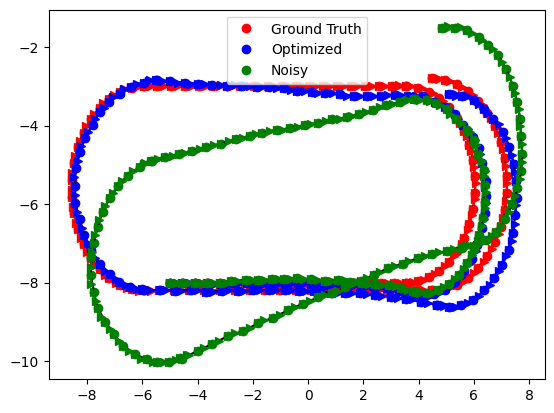

In [14]:
drawThree(X, Y, THETA, xOpt, yOpt, tOpt, xN, yN, tN)


In [15]:

def pose_symbol(i):
    	return gtsam.symbol_shorthand.X(i)

def ldmk_symbol(i):
    	return gtsam.symbol_shorthand.L(i)


def get_between_factor(p1, p2):
	T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
	T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
	T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
	dx = T2_1[0][2]
	dy = T2_1[1][2]
	dt = math.atan2(T2_1[1, 0], T2_1[0, 0])
	return gtsam.Pose2(dx, dy, dt)


In [16]:
# usually done by Bag of words / Global descriptor concepts
# write now we are using GT
def computeLoop(X, Y, THETA):
    pairs = []
    for i in range(0, 40, 2):
        p1 = [X[i],Y[i],THETA[i]]
        p2 = [X[i+80],Y[i+80],THETA[i+80]]
        pairs.append([i, i+80, get_between_factor(p1,p2)])
    return pairs

In [17]:


def gtsam_optimisation_python(xN, yN, tN, pairs, pose_sigma, print_log=False):
	graph = gtsam.NonlinearFactorGraph()
	initial = gtsam.Values()
    
	if print_log:
		print("Adding poses...")
        
	for idx in range(len(xN)):
		initial.insert(
			pose_symbol(idx), 
			gtsam.Pose2(xN[idx], yN[idx], tN[idx])
		)

	if print_log:
		print("Adding odom edges...")
        
	priorModel = gtsam.noiseModel.Diagonal.Sigmas(pose_sigma)
	graph.add(gtsam.PriorFactorPose2(pose_symbol(0), gtsam.Pose2(xN[0], yN[0], tN[0]), priorModel))
	for idx in range(len(xN)-1):
			graph.add(gtsam.BetweenFactorPose2(
				pose_symbol(idx),
				pose_symbol(idx+1),
				get_between_factor([xN[idx],yN[idx],tN[idx]],[xN[idx+1],yN[idx+1],tN[idx+1]]),
				priorModel
			))
    

	if print_log:
		print("Adding loop edges...")
	for LP in pairs:
			graph.add(gtsam.BetweenFactorPose2(
				pose_symbol(LP[0]),
				pose_symbol(LP[1]),
				LP[2],
				priorModel
			))
    
	
	params = gtsam.LevenbergMarquardtParams()
	if print_log:
		params.setVerbosity("Termination")  
	params.setMaxIterations(500)
	optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

	result = optimizer.optimize()

	if print_log:
		print("Optimization complete")
		print("initial error = ", graph.error(initial))
		print("final error = ", graph.error(result))
	marginals = gtsam.Marginals(graph, result)


	final_x = []
	final_y = [] 
	final_t = [] 
	final_ldmk = [] 
	for idx in range(len(xN)):
		final_x.append(result.atPose2(pose_symbol(idx)).x())
		final_y.append(result.atPose2(pose_symbol(idx)).y())
		final_t.append(result.atPose2(pose_symbol(idx)).theta())
		# print("X",idx ," -> ", marginals.marginalCovariance(pose_symbol(idx)))
        

	return final_x, final_y, final_t


Adding poses...
Adding odom edges...
Adding loop edges...
Optimization complete
initial error =  0.002580379862994586
final error =  1.991162986541631e-06
converged
errorThreshold: 1.99116298654e-06 <? 0
absoluteDecrease: 1.68446432756e-06 <? 1e-05
relativeDecrease: 0.458279412904 <? 1e-05
iterations: 4 >? 500


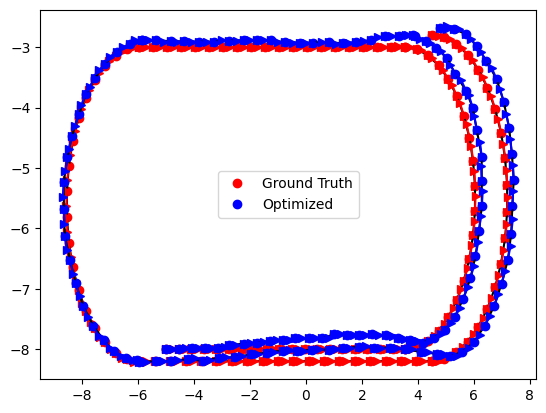

In [18]:
pose_sigma = np.array([ 100, 100, 100 ]) # x, y, theta
pairs = computeLoop(X, Y, THETA)
xOpt, yOpt, tOpt = gtsam_optimisation_python(xN, yN, tN, pairs,pose_sigma, True)
drawTwo(X, Y, THETA, xOpt, yOpt, tOpt)

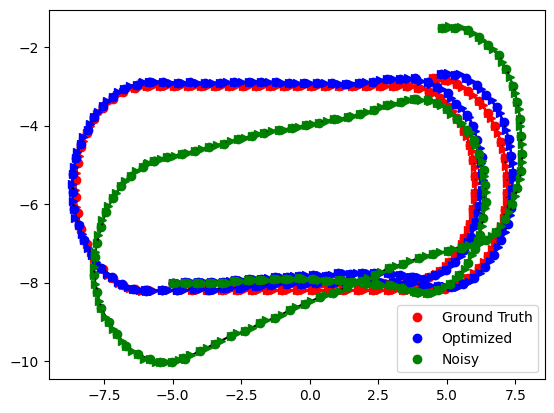

In [19]:
drawThree(X, Y, THETA, xOpt, yOpt, tOpt, xN, yN, tN)
